### Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils
from sklearn.utils import shuffle
import time

In [5]:
!unzip /content/brain_tumor_dataset.zip

Archive:  /content/brain_tumor_dataset.zip
   creating: brain_tumor_dataset/
   creating: brain_tumor_dataset/no/
  inflating: brain_tumor_dataset/no/N_1.jpg  
  inflating: brain_tumor_dataset/no/N_10.jpg  
  inflating: brain_tumor_dataset/no/N_11.jpg  
  inflating: brain_tumor_dataset/no/N_12.jpg  
  inflating: brain_tumor_dataset/no/N_13.jpg  
  inflating: brain_tumor_dataset/no/N_14.jpg  
  inflating: brain_tumor_dataset/no/N_15.jpg  
  inflating: brain_tumor_dataset/no/N_16.jpg  
  inflating: brain_tumor_dataset/no/N_17.jpg  
  inflating: brain_tumor_dataset/no/N_18.jpg  
  inflating: brain_tumor_dataset/no/N_19.jpg  
  inflating: brain_tumor_dataset/no/N_2.jpg  
  inflating: brain_tumor_dataset/no/N_20.jpg  
  inflating: brain_tumor_dataset/no/N_21.jpg  
  inflating: brain_tumor_dataset/no/N_22.jpg  
  inflating: brain_tumor_dataset/no/N_23.jpg  
  inflating: brain_tumor_dataset/no/N_24.jpg  
  inflating: brain_tumor_dataset/no/N_25.jpg  
  inflating: brain_tumor_dataset/no/N_26.j

### Formatting dataset

In [6]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [7]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


### Exploratory Data Analysis

In [8]:
yes_labels = os.listdir('brain_tumor_dataset/yes/')
count_yes_labels = len(yes_labels)

no_labels = os.listdir('brain_tumor_dataset/no/')
count_no_labels = len(no_labels)

print(count_yes_labels, count_no_labels)

23 35


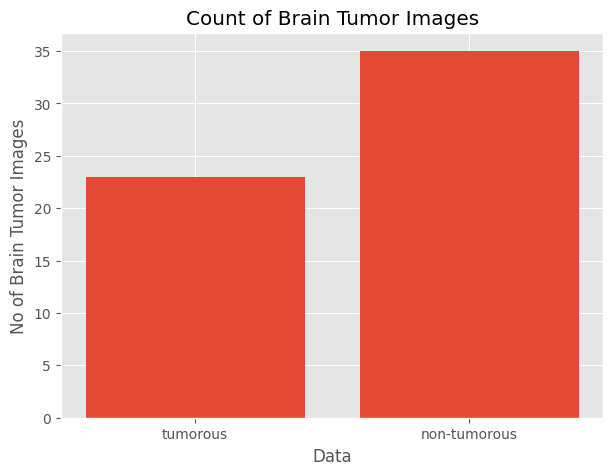

In [9]:
# Visulaizing the distribution of labels
data = {'tumorous': count_yes_labels, 'non-tumorous': count_no_labels}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(7,5))

plt.bar(typex, values)

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

### Data Augmentation

In [10]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int(sec_elapsed % (60 * 60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [11]:
def augment_data(file_dir, n_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i += 1
            if i > n_samples:
                break

In [12]:
def augment_data(file_dir, n_samples, save_to_dir):
    # Create directory if it does not exist
    os.makedirs(save_to_dir, exist_ok=True)

    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

    for filename in os.listdir(file_dir):
        image_path = os.path.join(file_dir, filename)
        image = cv2.imread(image_path)
        if image is None:
            continue  # skip corrupted or unreadable files
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1,
                                   save_to_dir=save_to_dir,
                                   save_prefix=save_prefix,
                                   save_format="jpg"):
            i += 1
            if i >= n_samples:
                break

# Paths
yes_path = 'brain_tumor_dataset/yes/'
no_path = 'brain_tumor_dataset/no/'
augmented_data_path = 'Dataset/augmented_data/'

# Timing and calling the function
start_time = time.time()

augment_data(file_dir=yes_path, n_samples=6, save_to_dir=os.path.join(augmented_data_path, 'yes'))
augment_data(file_dir=no_path, n_samples=9, save_to_dir=os.path.join(augmented_data_path, 'no'))

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 15.82 seconds


In [13]:
# Data Summary
def data_summary(main_path):
    yes_path = "Dataset/augmented_data/yes/"
    no_path = "Dataset/augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos * 100) / n
    neg_per = (n_neg * 100) / n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

data_summary(augmented_data_path)

Number of sample: 453
138 Number of positive sample in percentage: 30.4635761589404%
315 Number of negative sample in percentage: 69.5364238410596%


### Plotting the new dataset

138 315


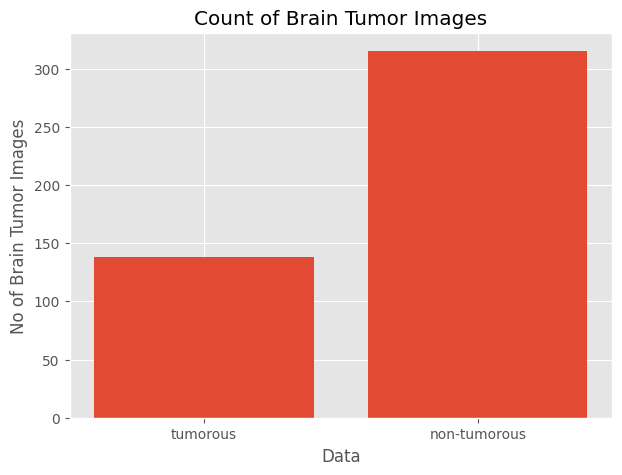

In [14]:
yes_labels = os.listdir('Dataset/augmented_data/yes/')
count_yes_labels = len(yes_labels)

no_labels = os.listdir('Dataset/augmented_data/no/')
count_no_labels = len(no_labels)

print(count_yes_labels, count_no_labels)


# Visulaizing the distribution of labels
data = {'tumorous': count_yes_labels, 'non-tumorous': count_no_labels}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(7,5))

plt.bar(typex, values)

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

### Data Preprocessing

In [15]:
def processed_image(image, plot=False):
    # Convert BGR to GRAY
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # GuassianBlur
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # Threshold
    thres = cv2.threshold(blur, 45, 255, cv2.THRESH_BINARY)[1]
    # Erode
    erode =cv2.erode(thres, None, iterations = 2)
    # Dilate
    dilate = cv2.dilate(erode, None, iterations = 2)
    # Find Contours
    cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

In [16]:
# img = cv2.imread('/content/Dataset/augmented_data/yes/aug_Y_100_0_2552.jpg')
# res = processed_image(img, True)

In [17]:
# # img = cv2.imread('/content/Dataset/augmented_data/no/aug_N_17_0_3421.jpg')
# res = processed_image(img, True)

In [18]:
# Preprocessing the entire dataset
# folder1 = 'Dataset/augmented_data/no/'
# folder2 = 'Dataset/augmented_data/yes/'
dir_path = 'Dataset/augmented_data/'

for filename in os.listdir(dir_path + 'no/'):
    img = cv2.imread(dir_path + 'no/' + filename)
    img = processed_image(img, False)
    cv2.imwrite(dir_path + 'no/' + filename, img)

for filename in os.listdir(dir_path + 'yes/'):
    img = cv2.imread(dir_path + 'yes/' + filename)
    img = processed_image(img, False)
    cv2.imwrite(dir_path + 'yes/' + filename, img)

In [19]:
# Preparing the datast for training

def load_data(dir_list, image_width, image_height):
    X = []
    y = []

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = processed_image(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            # Normalizing the image pixels
            image = image / 255.0
            X.append(image)
            # Assigning 1 for yes, 0 for no
            if directory[-3 : ] == "yes":
                y.append(1)
            else:
                y.append(0)

    X = np.array(X)
    y = np.array(y)

    # Shuffling to prevent model from learning patterns
    X, y = shuffle(X, y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X, y

In [20]:
augmented_path = 'Dataset/augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = 240, 240

X,y = load_data([augmeneted_yes, augmeneted_no], IMAGE_WIDTH, IMAGE_HEIGHT)

Number of example is : 453
X SHAPE is : (453, 240, 240, 3)
y SHAPE is : (453,)


In [21]:
# Visualize some preprocessed images
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)
            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()


In [22]:
plot_sample_images(X, y)

Output hidden; open in https://colab.research.google.com to view.

### Splitting the dataset into train and test set

In [23]:
if not os.path.isdir('processed_data'):
    base_dir = 'Dataset/processed_data'
    os.mkdir(base_dir)


if not os.path.isdir('processed_data/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('processed_data/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('processed_data/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)


if not os.path.isdir('processed_data/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('processed_data/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('processed_data/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)


if not os.path.isdir('processed_data/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('processed_data/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('processed_data/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [24]:
original_dataset_tumorours = os.path.join('Dataset/augmented_data','yes/')
original_dataset_nontumorours = os.path.join('Dataset/augmented_data','no/')

In [25]:
# Data Summary
def data_summary(main_path):
    yes_path = "Dataset/augmented_data/yes/"
    no_path = "Dataset/augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos * 100) / n
    neg_per = (n_neg * 100) / n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

data_summary(augmented_data_path)

Number of sample: 453
138 Number of positive sample in percentage: 30.4635761589404%
315 Number of negative sample in percentage: 69.5364238410596%


In [26]:
import os
import shutil

# Load file names from the 'no' class
files = os.listdir('Dataset/augmented_data/no/')
total_files = len(files)

# Shuffle files if needed to randomize
import random
random.shuffle(files)

# Define split sizes
train_split = int(0.70 * total_files)  # 70%
test_split = int(0.15 * total_files)   # 15%
valid_split = total_files - train_split - test_split  # rest for validation

# Split files
train_files = files[:train_split]
test_files = files[train_split:train_split + test_split]
valid_files = files[train_split + test_split:]

# Copy files to respective directories
for fname in train_files:
    src = os.path.join('Dataset/augmented_data/no/', fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

for fname in test_files:
    src = os.path.join('Dataset/augmented_data/no/', fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

for fname in valid_files:
    src = os.path.join('Dataset/augmented_data/no/', fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)


### Building the model

In [27]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0 / 255)
valid_data_gen = ImageDataGenerator(rescale=1.0 / 255)

In [28]:
train_data = train_datagen.flow_from_directory('Dataset/processed_data/train/', batch_size=32, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode = 'rgb')

Found 220 images belonging to 2 classes.


In [29]:
test_data = train_datagen.flow_from_directory('Dataset/processed_data/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 47 images belonging to 2 classes.


In [30]:
valid_data = train_datagen.flow_from_directory('Dataset/processed_data/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 48 images belonging to 2 classes.


In [31]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_1 = Model(base_model.input, output)
model_1.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [32]:
filepath = 'model.keras.weights.h5'
ES = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
MCP = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=True, mode='auto',save_freq='epoch')
LRO_V = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [33]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_1.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [34]:
model_1_res = model_1.fit(train_data, steps_per_epoch = 10, epochs = 20, callbacks = [ES, MCP, LRO_V], validation_data = valid_data)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 7/10 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7833 - loss: 0.4131 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.00350, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.8224 - loss: 0.3511 - val_accuracy: 1.0000 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


 7/10 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step - accuracy: 1.0000 - loss: 0.0031
Epoch 2: val_loss improved from 0.00350 to 0.00025, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 2.4535e-04 - learning_rate: 1.0000e-04
Epoch 3/20
 7/10 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step - accuracy: 1.0000 - loss: 3.2681e-04
Epoch 3: val_loss improved from 0.00025 to 0.00009, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 3.0613e-04 - val_accuracy: 1.0000 - val_loss: 8.8893e-05 - learning_rate: 1.0000e-04
Epoch 4/20
 7/10 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step - accuracy: 1.0000 - loss: 1.1276e-04
Epoch 4: val_loss improved from 0.00009 to 0.00005, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 1.0000 - loss: 1.1024e-04 - val_accuracy: 1.0000 - val_loss: 4.8606e-05 - learning_rate: 1.0000e-04
Epoch 5/20
 7/10 ━━━━━━

### Plotting Performance

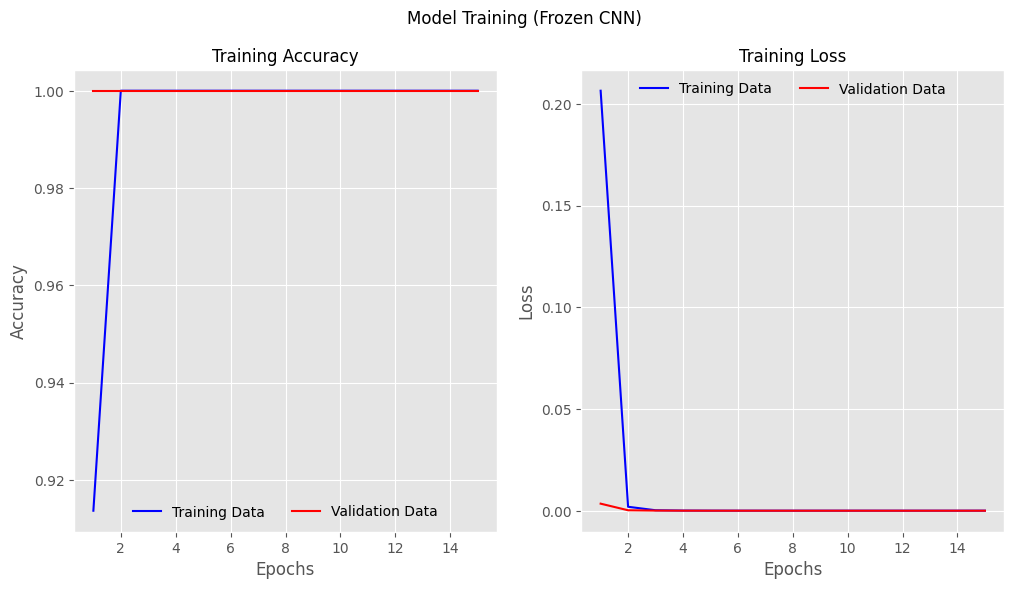

In [35]:
# Plot performance
def plot_performance(stored_model, name):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
    max_epoch = len(stored_model.history['accuracy']) + 1
    epochs_list = list(range(1, max_epoch))

    ax1.plot(epochs_list, stored_model.history['accuracy'], color='b', linestyle='-', label='Training Data')
    ax1.plot(epochs_list, stored_model.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
    ax1.set_title('Training Accuracy', fontsize=12)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(frameon=False, loc='lower center', ncol=2)

    ax2.plot(epochs_list, stored_model.history['loss'], color='b', linestyle='-', label='Training Data')
    ax2.plot(epochs_list, stored_model.history['val_loss'], color='r', linestyle='-', label='Validation Data')
    ax2.set_title('Training Loss', fontsize=12)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(frameon=False, loc='upper center', ncol=2)
    plt.savefig(f"training_{name}_cnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

plot_performance(model_1_res, 'model_1')

In [36]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_1.save_weights(filepath="model_weights/vgg19_model_1.keras.weights.h5", overwrite=True)

In [37]:
model_1.load_weights("model_weights/vgg19_model_1.keras.weights.h5")
vgg_val_eval_01 = model_1.evaluate(valid_data)
vgg_test_eval_01 = model_1.evaluate(test_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 1.0000 - loss: 2.7613e-05


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 1.0000 - loss: 2.6852e-05


In [38]:
filenames = test_data.filenames
nb_sample = len(filenames)

vgg_prediction = model_1.predict(test_data, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step  


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [39]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [40]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
# base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_2 = Model(base_model.inputs, output)
model_2.load_weights('model_weights/vgg19_model_1.keras.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_2.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])
model_2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model_2_res = model_2.fit(train_data, steps_per_epoch=10, epochs = 50, callbacks=[ES, MCP, LRO_V], validation_data=valid_data)

Epoch 1/50
 7/10 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 1.0000 - loss: 4.5215e-05  
Epoch 1: val_loss did not improve from 0.00003
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 1.0000 - loss: 4.4994e-05 - val_accuracy: 1.0000 - val_loss: 2.9106e-05 - learning_rate: 1.0000e-04
Epoch 2/50


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


 7/10 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step - accuracy: 1.0000 - loss: 4.6690e-05
Epoch 2: val_loss did not improve from 0.00003
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 546ms/step - accuracy: 1.0000 - loss: 4.6801e-05 - val_accuracy: 1.0000 - val_loss: 2.8577e-05 - learning_rate: 1.0000e-04
Epoch 3/50
 7/10 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 1.0000 - loss: 4.2706e-05
Epoch 3: val_loss did not improve from 0.00003
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 543ms/step - accuracy: 1.0000 - loss: 4.3213e-05 - val_accuracy: 1.0000 - val_loss: 2.7286e-05 - learning_rate: 1.0000e-04
Epoch 4/50
 7/10 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step - accuracy: 1.0000 - loss: 4.6286e-05
Epoch 4: val_loss improved from 0.00003 to 0.00002, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 1.0000 - loss: 4.6167e-05 - val_accuracy: 1.0000 - val_loss: 2.4882e-05 - learning_rate: 1.0000e-04
Epoch 5/50
 7/10 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step - accuracy: 1.0000 - loss: 4.3195e-05
Epoch 5: 

In [42]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_2.save_weights(filepath="model_weights/vgg_unfrozen.keras.weights.h5", overwrite=True)

In [43]:
model_2.load_weights("model_weights/vgg_unfrozen.keras.weights.h5")
vgg_val_eval_03 = model_2.evaluate(valid_data)
vgg_test_eval_03 = model_2.evaluate(test_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 1.0000 - loss: 2.6394e-05
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 990ms/step - accuracy: 1.0000 - loss: 3.0402e-05


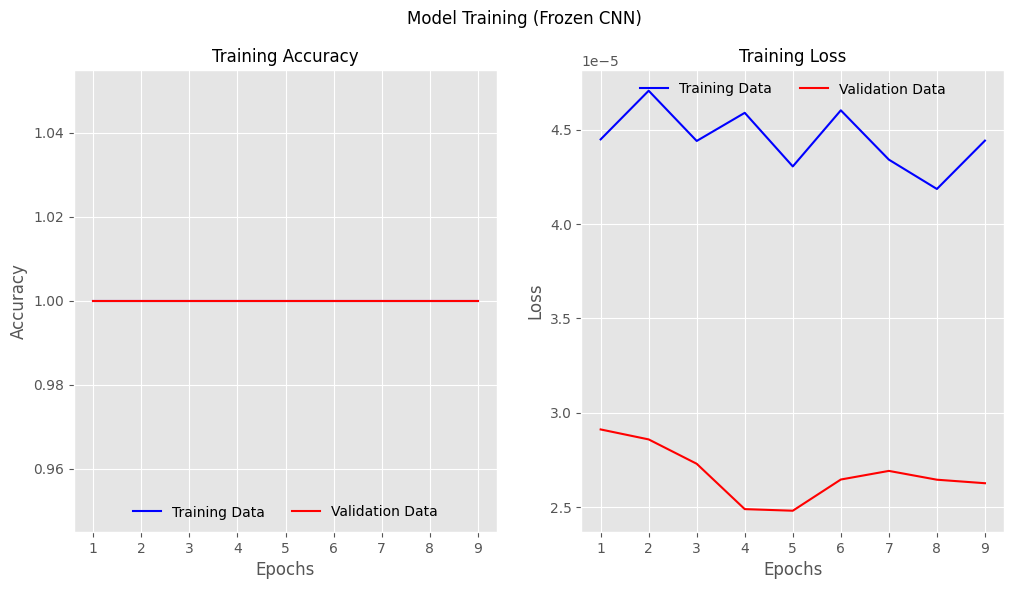

In [44]:
plot_performance(model_2_res, 'model_2')